In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, PredefinedSplit, RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from scipy.stats import mode, pearsonr

In [ ]:
np.random.seed(13)

## Pre-Processing Data

Bock, R. (2004). MAGIC Gamma Telescope [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C52C8B.

The data below were generated by a Monte Carlo (MC) simulation to mimic how a ground-based Cherenkov gamma telescope detects high-energy gamma particles using an imaging technique. This telescope observes high-energy gamma rays by capturing the radiation emitted by charged particles produced in electromagnetic showers, which are triggered by gamma rays as they travel through the atmosphere.

In [91]:

DATA_DF = pd.read_csv('telescope_data.csv')

print(DATA_DF.columns)
for col in DATA_DF.columns:
    DATA_DF[col] = pd.to_numeric(DATA_DF[col], errors='ignore')

DATA_DF['class'] = DATA_DF['class'].astype('category')


Index(['Unnamed: 0', 'fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym',
       'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class'],
      dtype='object')



#### Features
fLength	Feature	Continuous	major axis of ellipse	mm	no


fWidth	Feature	Continuous	minor axis of ellipse	mm	no


fSize	Feature	Continuous	10-log of sum of content of all pixels	#phot	no


fConc	Feature	Continuous	ratio of sum of two highest pixels over fSize		no


fConc1	Feature	Continuous	ratio of highest pixel over fSize		no


fAsym	Feature	Continuous	distance from highest pixel to center, projected onto major axis		no


fM3Long	Feature	Continuous	3rd root of third moment along major axis	mm	no


fM3Trans	Feature	Continuous	3rd root of third moment along minor axis	mm	no


fAlpha	Feature	Continuous	angle of major axis with vector to origin	deg	no


fDist	Feature	Continuous	distance from origin to center of ellipse	mm	no

## Question 1
Display the statistical values for each of the attributes, along with visualizations (e.g., histogram) of the distributions for each attribute. Are there any attributes that might require special treatment? If so, what special treatment might they require?

In [55]:
DATA_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Unnamed: 0  19020 non-null  int64   
 1   fLength     19020 non-null  float64 
 2   fWidth      19020 non-null  float64 
 3   fSize       19020 non-null  float64 
 4   fConc       19020 non-null  float64 
 5   fConc1      19020 non-null  float64 
 6   fAsym       19020 non-null  float64 
 7   fM3Long     19020 non-null  float64 
 8   fM3Trans    19020 non-null  float64 
 9   fAlpha      19020 non-null  float64 
 10  fDist       19020 non-null  float64 
 11  class       19020 non-null  category
dtypes: category(1), float64(10), int64(1)
memory usage: 1.6 MB


Take a random sample of 5000 rows to improve compute times

### Statistical Values

Basic Statistical Values

In [56]:
DATA_DF.describe()

,Unnamed: 0,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
count,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000
mean,9509.500000,53.250154,22.180966,2.825017,0.380327,0.214657,-4.331745,10.545545,0.249726,27.645707,193.818026
std,5490.745396,42.364855,18.346056,0.472599,0.182813,0.110511,59.206062,51.000118,20.827439,26.103621,74.731787
min,0.000000,4.283500,0.000000,1.941300,0.013100,0.000300,-457.916100,-331.780000,-205.894700,0.000000,1.282600
25%,4754.750000,24.336000,11.863800,2.477100,0.235800,0.128475,-20.586550,-12.842775,-10.849375,5.547925,142.492250
50%,9509.500000,37.147700,17.139900,2.739600,0.354150,0.196500,4.013050,15.314100,0.666200,17.679500,191.851450
75%,14264.250000,70.122175,24.739475,3.101600,0.503700,0.285225,24.063700,35.837800,10.946425,45.883550,240.563825
max,19019.000000,334.177000,256.382000,5.323300,0.893000,0.675200,575.240700,238.321000,179.851000,90.000000,495.561000


Check Null and Missing Values

In [57]:
DATA_DF.isnull().sum()

,0
Unnamed: 0,0
fLength,0
fWidth,0
fSize,0
fConc,0
fConc1,0
fAsym,0
fM3Long,0
fM3Trans,0
fAlpha,0


Plotting Histograms

In [58]:
COLORMAP = plt.cm.plasma
SNS_COLORMAP = sns.color_palette("plasma", n_colors=len(DATA_DF.columns))
SNS_COLORMAP

[(0.21435, 0.016973, 0.599239),
 (0.343925, 0.004991, 0.64471),
 (0.46555, 0.004545, 0.660139),
 (0.573632, 0.060028, 0.637349),
 (0.674522, 0.147419, 0.578688),
 (0.760264, 0.235976, 0.505794),
 (0.830018, 0.320172, 0.437836),
 (0.89325, 0.411048, 0.369768),
 (0.944844, 0.507658, 0.302433),
 (0.979233, 0.607532, 0.238013),
 (0.994474, 0.722691, 0.174381),
 (0.98119, 0.848329, 0.142279)]

Selecting the top 10 features with the highest absolute correlation statistic to our target value, these features were pulled from Question 2 Pearson Correlation Coefficient. This is done to simplify the amount of visualizaions of the histograms and scatter plots

array([[<Axes: title={'center': 'Unnamed: 0'}>,
        <Axes: title={'center': 'fLength'}>,
        <Axes: title={'center': 'fWidth'}>],
       [<Axes: title={'center': 'fSize'}>,
        <Axes: title={'center': 'fConc'}>,
        <Axes: title={'center': 'fConc1'}>],
       [<Axes: title={'center': 'fAsym'}>,
        <Axes: title={'center': 'fM3Long'}>,
        <Axes: title={'center': 'fM3Trans'}>],
       [<Axes: title={'center': 'fAlpha'}>,
        <Axes: title={'center': 'fDist'}>, <Axes: >]], dtype=object)

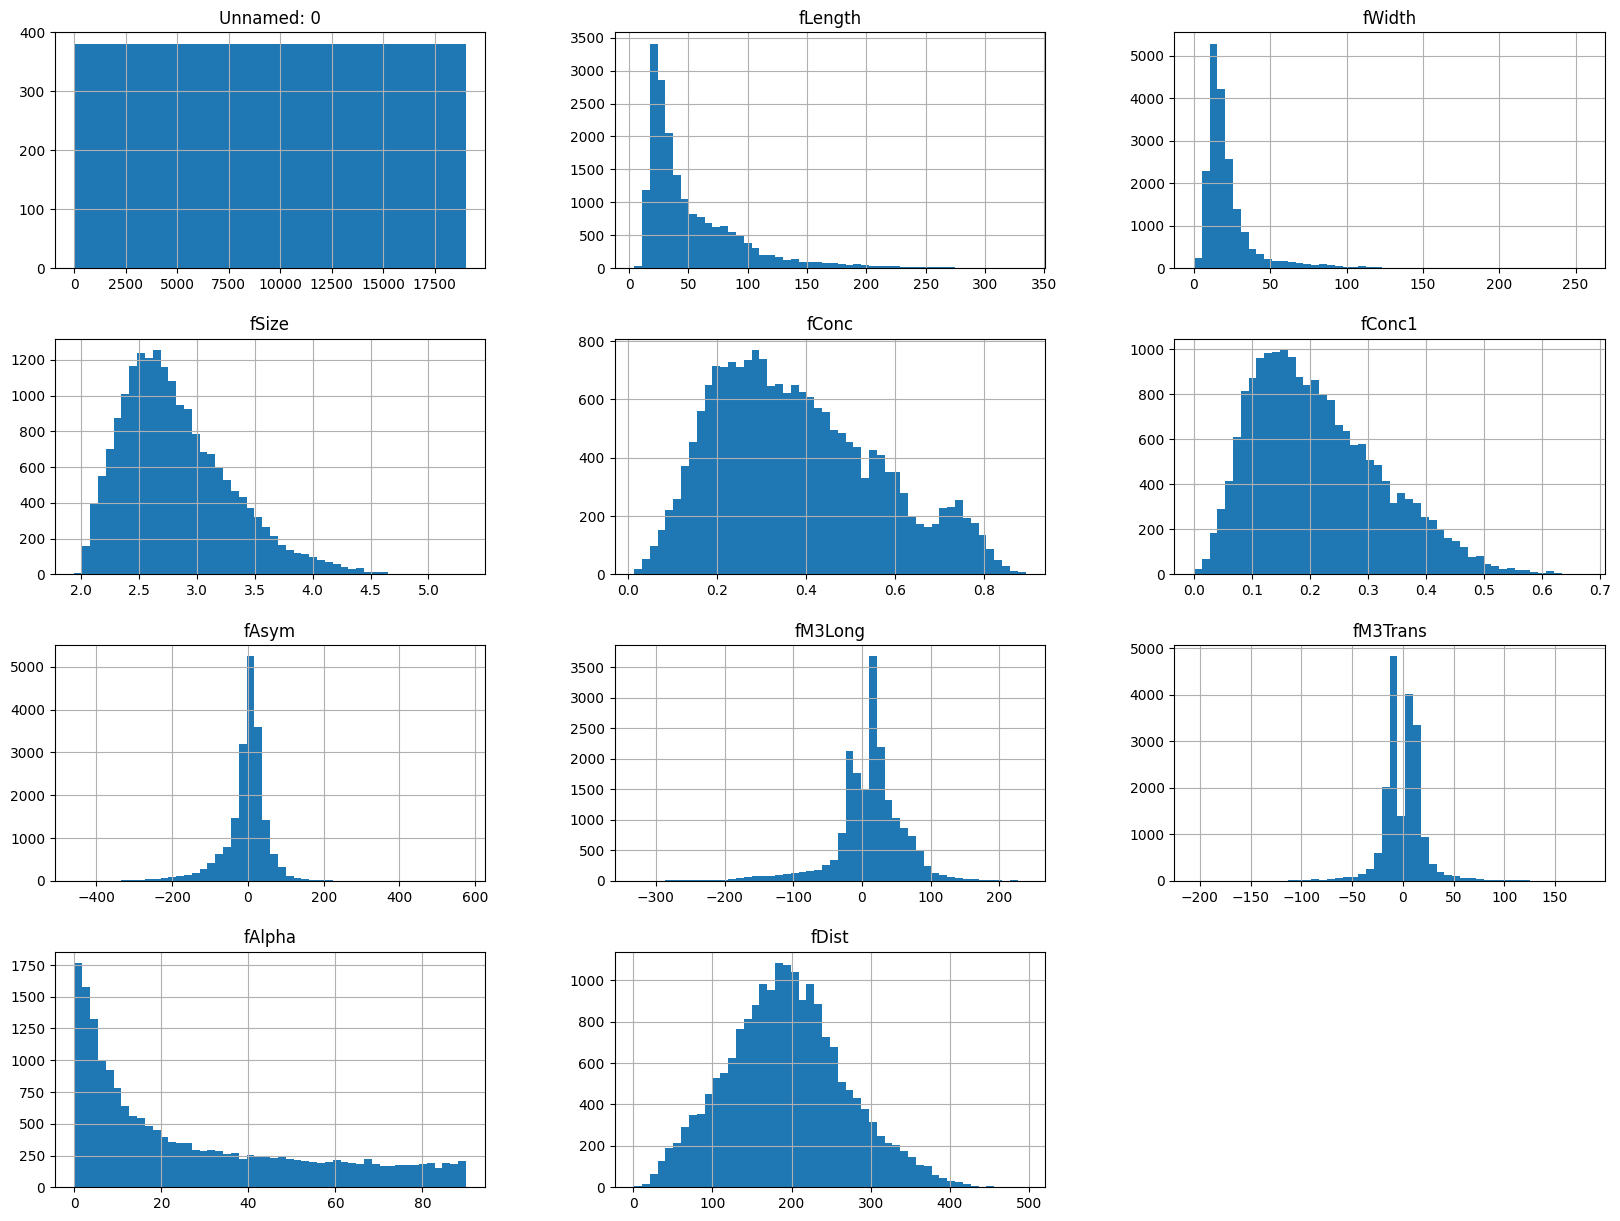

In [60]:

DATA_DF.hist(bins=50,figsize=(20,15))

Plotting Box and Whiskers for features

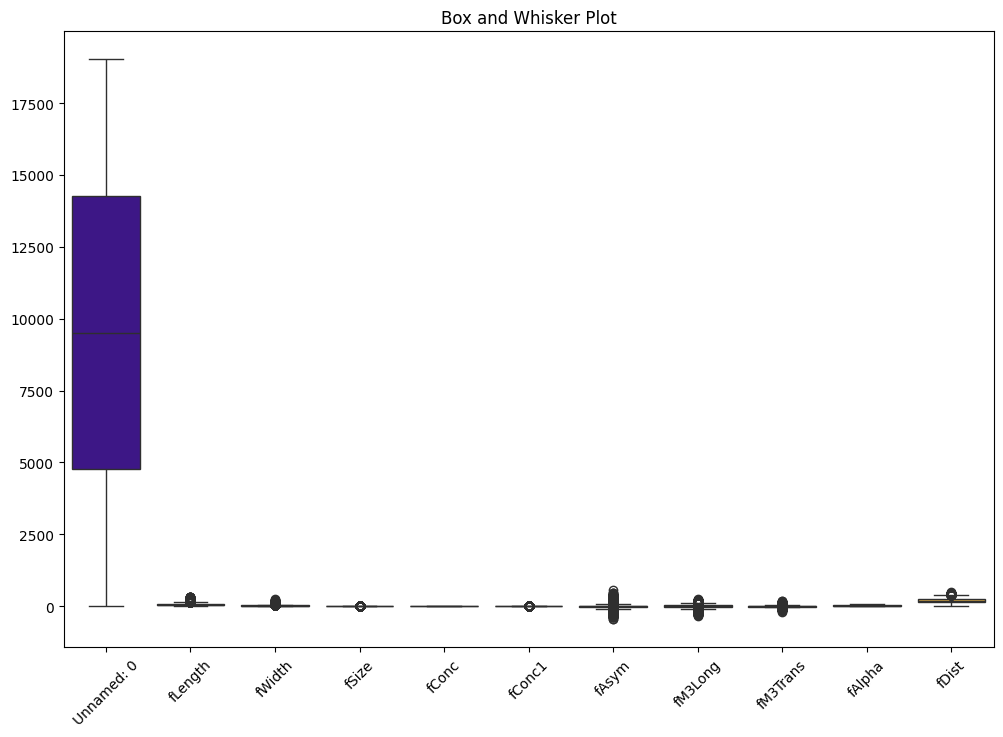

In [61]:
plt.figure(figsize=(12, 8))
# Assuming you want to create a boxplot for all numerical columns in DATA_DF:
sns.boxplot(data=DATA_DF, palette=SNS_COLORMAP)
plt.xticks(rotation=45)
plt.title("Box and Whisker Plot")
plt.show()

### Answer

1. The stastical values of all the attributes have been studied along with the histogram and boxplots. Observations are:

    a. There are no Null values in the dataset.

    b. Features in data have small variances

    c. There are large amounts outliers in fAsym

    d. The target variable Class has equal number of entries for each type.

    f. All the features are continuous and the target is categorical.

    e. Treatments required by features:

    a. Standard scaling will be used to standardize the data before fitting a model.

    b. Due to the small amount of outliers and narrow distributions, no outliers will be dropped

# Question 2
Analyze and discuss the relationships between the data attributes and between the data attributes and labels. This involves computing the Pearson Correlation Coefficient (PCC) and generating scatter plots.


In [62]:

TARGET_VARIABLE = 'class'
FEATURES = DATA_DF.columns.drop([TARGET_VARIABLE])

In [63]:
y= DATA_DF['class']
X= DATA_DF.drop(['class'],axis=1)

scaler = StandardScaler()
scaled = scaler.fit_transform(X)
scaled_X = pd.DataFrame(scaled, columns=X.columns)

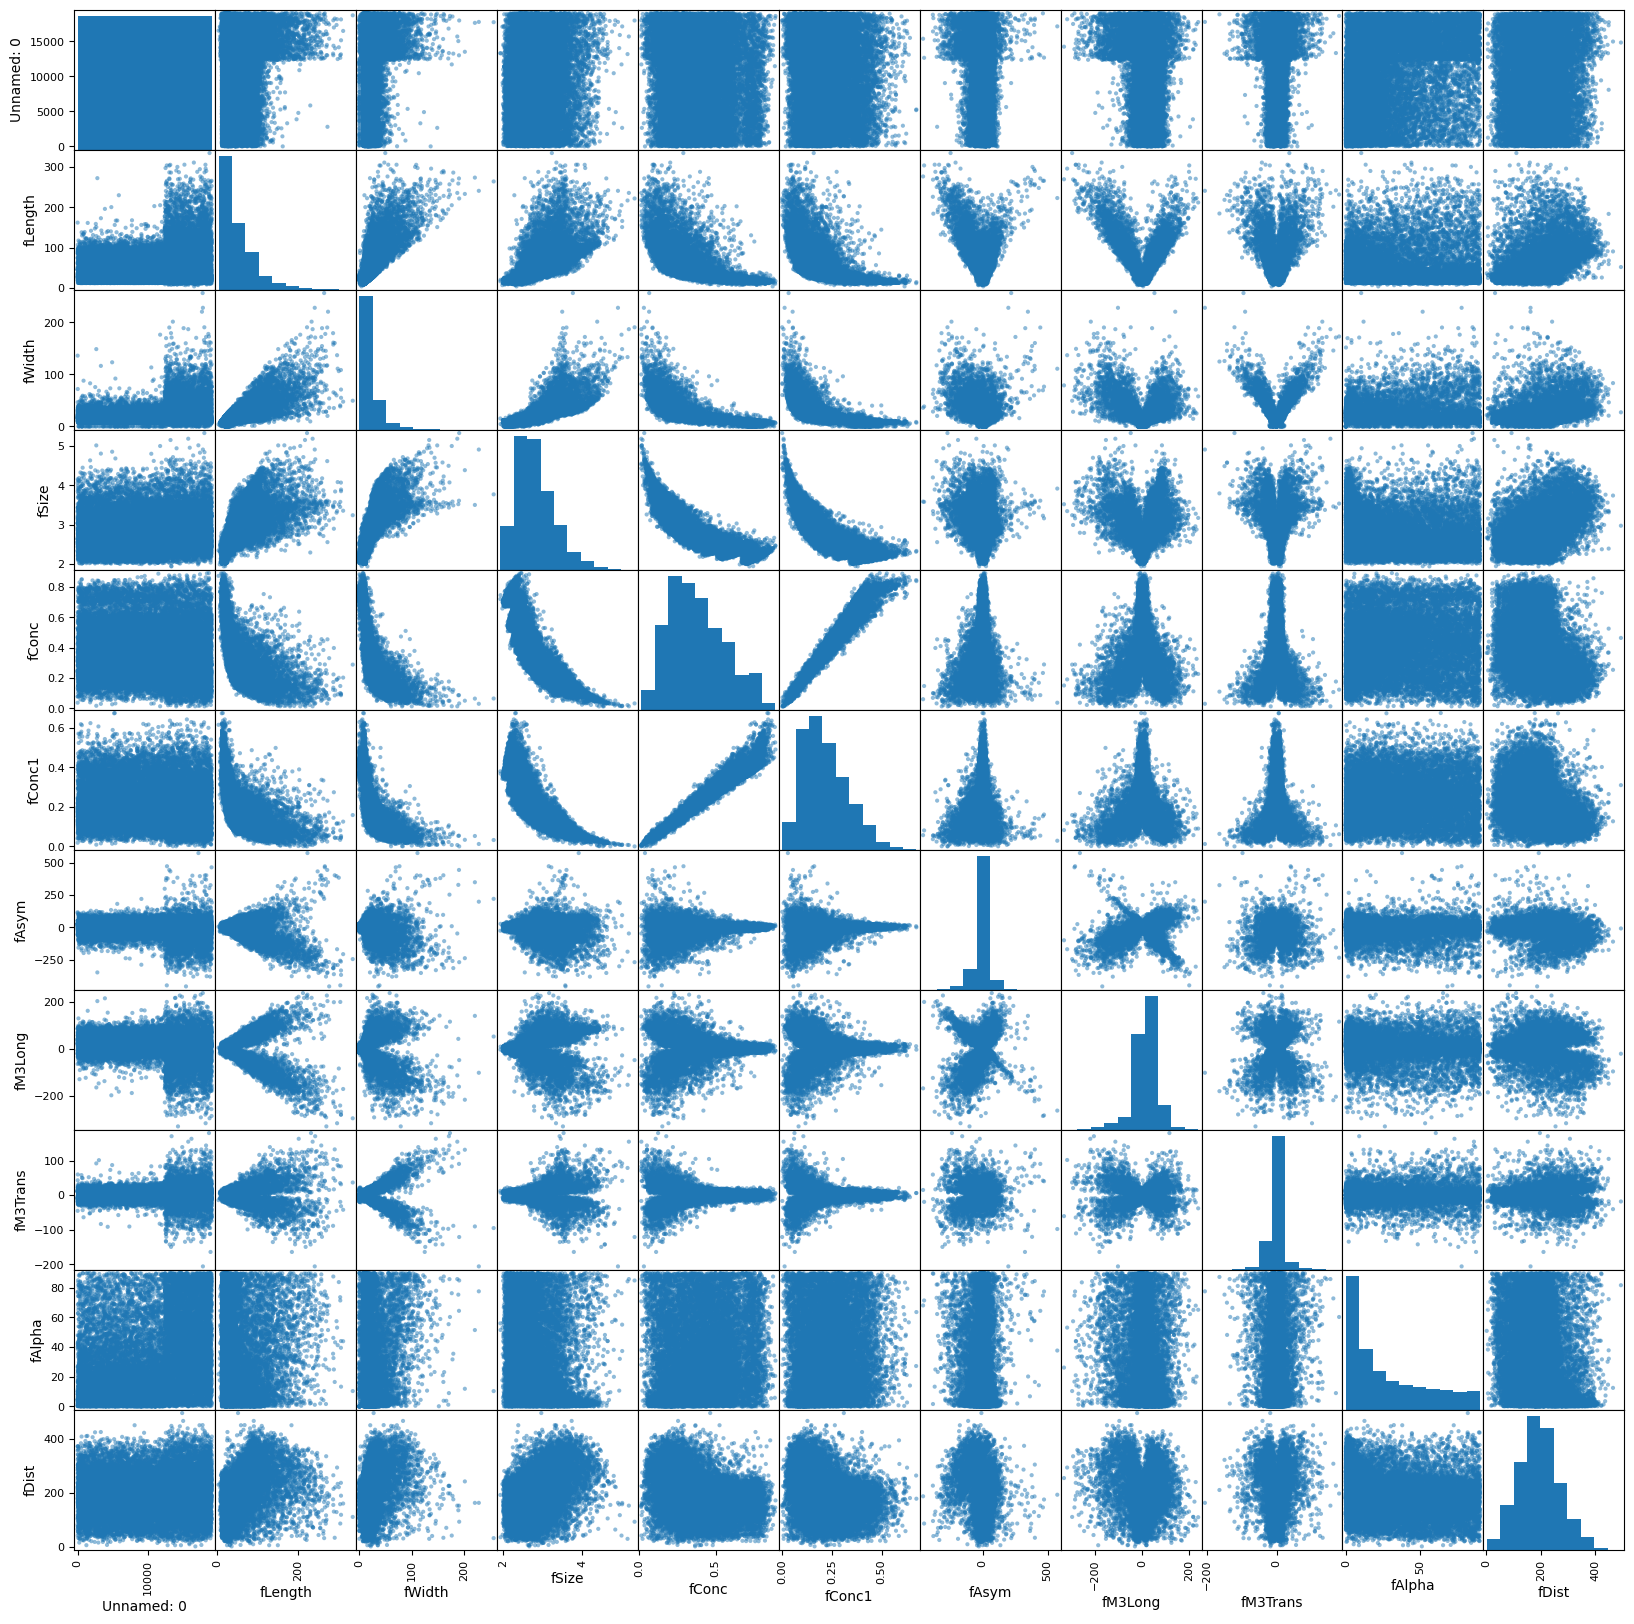

In [64]:
corr_matrix = scaled_X.corr()
pd.plotting.scatter_matrix(X, figsize=(20, 20), diagonal='hist')
plt.show()

### Scatter Plots

Generating the pair wise scatter plots of the top 10 features with the largest absolute correlation statistic to the target feature. Within each scatter plot we also identify the classes of each point with yellow indicating fradualant activity and blue indicating normal activity

### Correlation Matrix

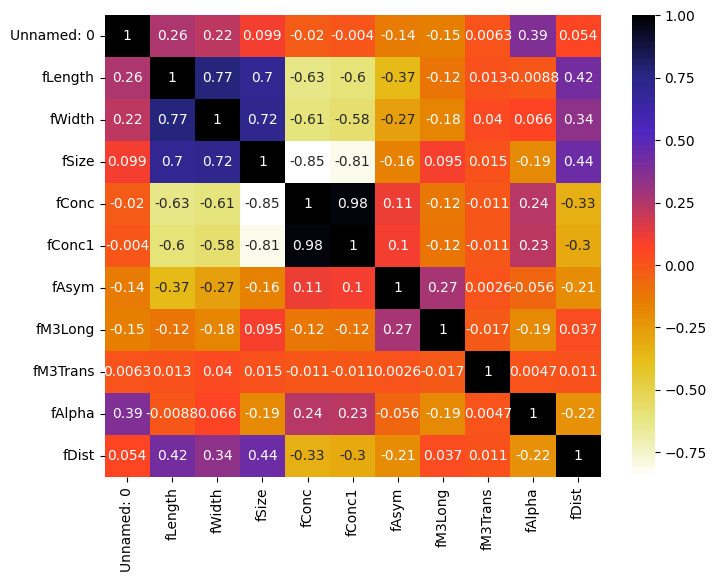

In [65]:
plt.figure(figsize=(8,6))
cor = scaled_X.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

I have observed moderate to strong positive correlation (> 0.5) among the following attributes:

• fLength & fWidth (0.77)

• fLength & fSize (0.7)

• fWidth & fSize (0.72)

• fConc & fConc1 (0.98)

I have observed moderate to strong negative correlation (> -0.5) among the following attributes:

• fLength & fConc (-0.63) & fLength & fConc1 (-0.6)

• fWidth & fConc (-0.61) & fWidth & fConc1 (-0.58)

• fSize & fConc (-0.85) & fSize & fConc1 (-0.81)

 Due to the strong correlation between fConc and fConc1 (0.98), the decision has been made to exclude fConc1 from further analysis.

### Observations

1. Relationship between the label and features:

    We notice that when calculating the pearson correlation coefficient 93% of the features provide statistically significant results.  The highest absolute correlation statistic was between the target class and feature v14 with a statistic of -.8.

2. Relationship between features:

    a. We notice that whitin the top 10 features there is evidence of linear patterns. This is supported by the large coefficient numbers within the correlation matrix. Another important observation is  within the scatter plots there seems to be a clear divide between fradudalnt and normal activities, indicated by the different colors of points.
    

    

# Question 3


### Splitting

Scale Data

In [92]:
scaled_X.drop(['fConc1'],axis=1,inplace=True)
scaler = StandardScaler()
# scaler = MinMaxScaler()
DATA_DF[FEATURES] = scaler.fit_transform(DATA_DF[FEATURES])

Split data into Train-Test-Validate sets

In [93]:
# Train Test Validate Split

train_data, test_data = train_test_split(DATA_DF, test_size=0.25, random_state=99)
train_data, validate_data = train_test_split(train_data, test_size=0.25, random_state=99)


Splitting X and Y labels

In [94]:
X_train = train_data.drop(columns=[TARGET_VARIABLE])
y_train = train_data[TARGET_VARIABLE]

X_validate = validate_data.drop(columns=[TARGET_VARIABLE])
y_validate = validate_data[TARGET_VARIABLE]

X_test = test_data.drop(columns=[TARGET_VARIABLE])
y_test = test_data[TARGET_VARIABLE]

Checking the amount of data in each split

In [95]:
print("----------- Shape ------------")
print("training data: ", train_data.shape)
print("validate data: ", validate_data.shape)
print("test data: ", test_data.shape)

print("\n----------- Proportion ------------")
print(f"Training Data: {len(train_data)/ len(DATA_DF):.3f}%")
print(f"Validation Data: {len(validate_data)/ len(DATA_DF):.3f}%")
print(f"Testing Data: {len(test_data)/ len(DATA_DF):.3f}")

----------- Shape ------------
training data:  (10698, 12)
validate data:  (3567, 12)
test data:  (4755, 12)

----------- Proportion ------------
Training Data: 0.562%
Validation Data: 0.188%
Testing Data: 0.250


### Check validity of splits

Ensure that each target class is represented in each split

In [96]:

print("Target distribution in training data: ")
print(train_data[TARGET_VARIABLE].value_counts())

print("Target distribution in test data: ")
print(test_data[TARGET_VARIABLE].value_counts())

print("Target validate in training data: ")
print(validate_data[TARGET_VARIABLE].value_counts())

Target distribution in training data: 
class
g    6879
h    3819
Name: count, dtype: int64
Target distribution in test data: 
class
g    3130
h    1625
Name: count, dtype: int64
Target validate in training data: 
class
g    2323
h    1244
Name: count, dtype: int64


Checking the box and whisker plots for each column for each split

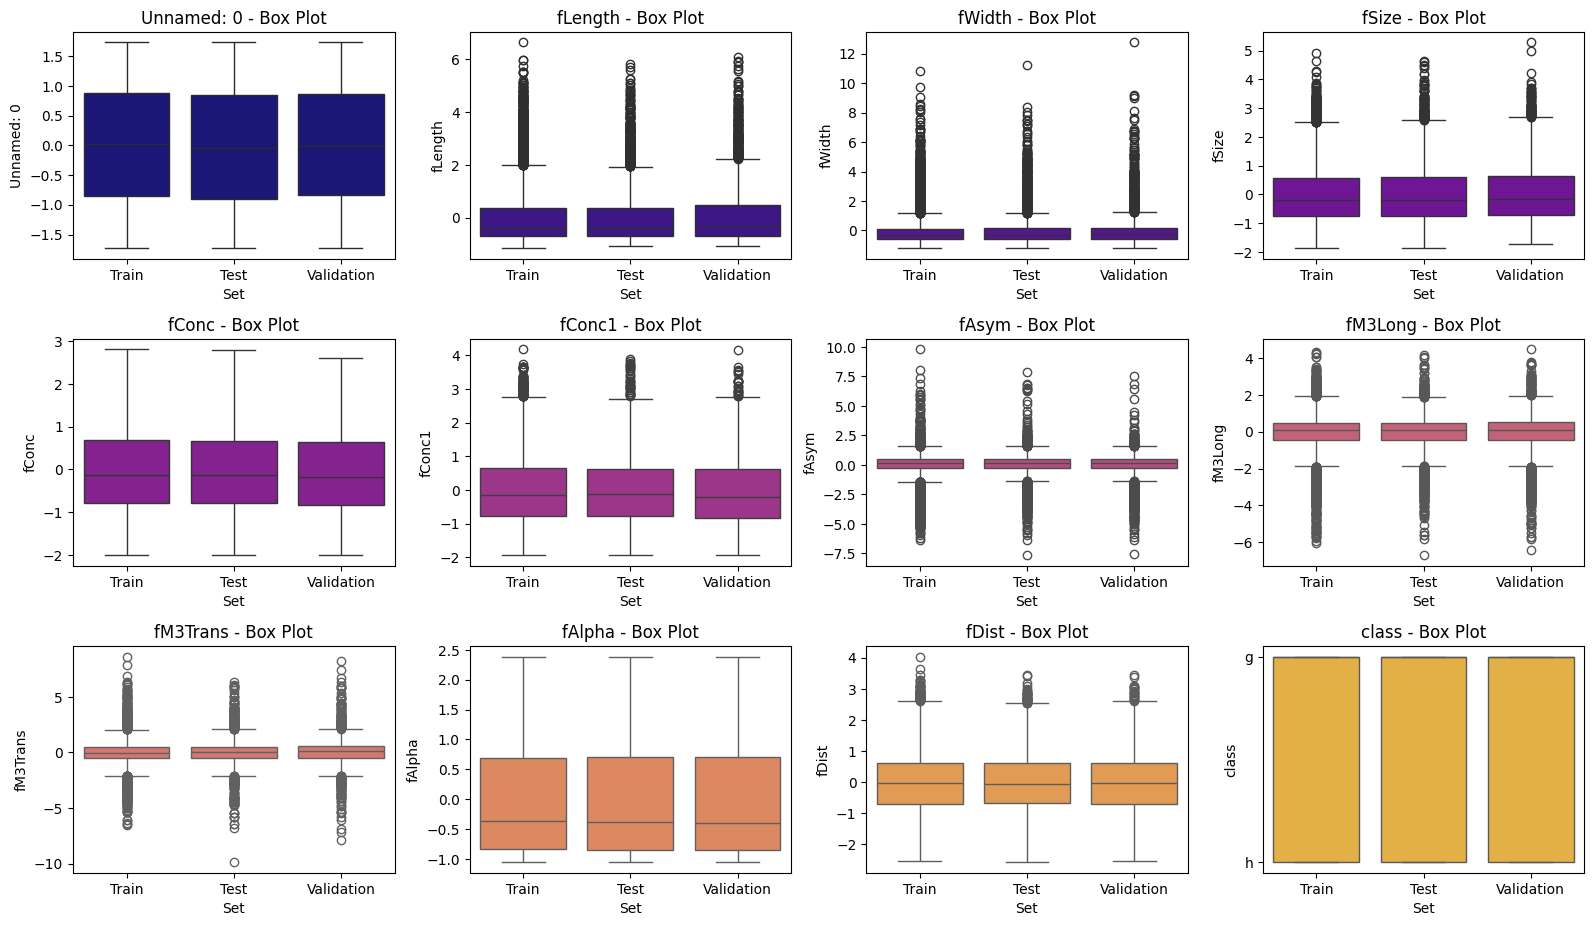

In [97]:
train_data["Set"] = "Train"
test_data["Set"] = "Test"
validate_data["Set"] = "Validation"
combined_data = pd.concat([train_data, test_data, validate_data])

# combined_data = combined_data[TOP_15_FEATURES + ['Set']]


plt.figure(figsize=(16, 12))
for i, column in enumerate(combined_data.columns[:-1]):
    plt.subplot(4, 4, i + 1)
    color = COLORMAP(i / len(combined_data.columns))
    sns.boxplot(x="Set", y=column, data=combined_data, color=color)
    plt.title(f"{column} - Box Plot")

plt.tight_layout()
plt.show()

Check the mean and std of each column for each split

In [98]:
summary_df = pd.DataFrame()

for column in DATA_DF.columns:
    if column not in ['class']:
        stats = {
            f"train_mean": train_data[column].mean(),
            f"train_std": train_data[column].std(),
            f"test_mean": test_data[column].mean(),
            f"test_std": test_data[column].std(),
            f"validate_mean": validate_data[column].mean(),
            f"validate_std": validate_data[column].std()
        }
        summary_df = pd.concat([summary_df, pd.DataFrame(stats, index=[column])])

summary_df.index.name = 'Column'
summary_df.reset_index(inplace=True)

summary_df

,Column,train_mean,train_std,test_mean,test_std,validate_mean,validate_std
0,Unnamed: 0,0.011572,1.004656,-0.028881,1.000461,0.003794,0.984929
1,fLength,-0.007967,0.989930,-0.013646,0.982719,0.042084,1.050914
2,fWidth,-0.018611,0.960880,0.009665,1.035260,0.042934,1.064083
3,fSize,-0.016580,0.980252,0.000995,1.019884,0.048399,1.030261
4,fConc,0.013495,1.000650,-0.003855,0.998689,-0.035334,0.999308
5,fConc1,0.013088,1.002331,-0.004136,0.995033,-0.033739,0.999189
6,fAsym,0.005531,0.994192,0.004338,0.987799,-0.022370,1.033103
7,fM3Long,0.001380,0.995846,0.000255,0.962209,-0.004479,1.060445
8,fM3Trans,-0.011357,0.970858,0.002538,1.014200,0.030677,1.064736
9,fAlpha,0.001912,0.995344,0.003770,1.008434,-0.010760,1.002988


### Answer

1. The dataset has been split into Train, Validate and Test components using the train test split, which splits the matrix into a random subset given by the test size. For this model we split the data into ~56% training, ~19% , and 25% testing

2. The split has been verified using mean and standard deviation along with whisker plots to check if it is representative of the original data. The findings state that the split is indeed representative of the data with some minor expected noise.

# Question 4
Train different classifiers and tweak the hyperparameters to improve performance (you can use the grid search if you want or manually try different values). Report training, validation and testing performance (classification accuracy, precision, recall and F1 score) and discuss the impact of the hyperparameters (use markdown cells in Jupyter Notebook to clearly indicate each solution):


Helpers for grid search

In [99]:
X_pre_defined = np.concatenate((X_train, X_validate), axis=0)
y_pre_defined = np.concatenate((y_train, y_validate), axis=0)

split_index = [-1] * len(X_train) + [0] * len(X_validate)
predefined_split = PredefinedSplit(test_fold = split_index)


def evaluate_model(X_train, y_train, X_validate, y_validate, X_test, y_test, model):
    # Training predictions and metrics
    y_train_pred = model.predict(X_train)
    print("---------------------- Training Metrics ----------------------")
    print("Accuracy: ", round(accuracy_score(y_train, y_train_pred), 3))
    print("Precision: ", precision_score(y_train, y_train_pred, average="macro").round(3))
    print("Recall: ", recall_score(y_train, y_train_pred, average="macro").round(3))
    print("F1 Score: ", f1_score(y_train, y_train_pred, average="macro").round(3))

    # Testing predictions and metrics
    y_validate_pred = model.predict(X_validate)
    print("---------------------- Validation Metrics ----------------------")
    print("Accuracy: ", round(accuracy_score(y_validate, y_validate_pred), 3))
    print("Precision: ", precision_score(y_validate, y_validate_pred, average="macro").round(3))
    print("Recall: ", recall_score(y_validate, y_validate_pred, average="macro").round(3))
    print("F1 Score: ", f1_score(y_validate, y_validate_pred, average="macro").round(3))

    # Testing predictions and metrics
    y_test_pred = model.predict(X_test)
    print("---------------------- Testing Metrics ----------------------")
    print("Accuracy: ", round(accuracy_score(y_test, y_test_pred), 3))
    print("Precision: ", precision_score(y_test, y_test_pred, average="macro").round(3))
    print("Recall: ", recall_score(y_test, y_test_pred, average="macro").round(3))
    print("F1 Score: ", f1_score(y_test, y_test_pred, average="macro").round(3))


### Logistic Regression

Use normal logisitic regression instead of the soft max because of binary target class

In [100]:
# Modelling
logreg = LogisticRegression(fit_intercept = True, max_iter = 50)

logreg.fit(X_train, y_train)
# Evaluating on training data
evaluate_model(X_train, y_train, X_validate, y_validate, X_test, y_test, logreg)


---------------------- Training Metrics ----------------------
Accuracy:  0.995
Precision:  0.995
Recall:  0.994
F1 Score:  0.994
---------------------- Validation Metrics ----------------------
Accuracy:  0.994
Precision:  0.993
Recall:  0.993
F1 Score:  0.993
---------------------- Testing Metrics ----------------------
Accuracy:  0.995
Precision:  0.994
Recall:  0.994
F1 Score:  0.994


#### Hyper Parameter Tuning using grid search

In [101]:

MODEL = LogisticRegression(fit_intercept=True)

# Define the base parameters and parameter grid
param_grid = {
    'solver': ['lbfgs', 'sag', 'saga', 'newton-cg'],
    'penalty': ['l1', 'l2', 'elsaticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': range(10,220,10)
}


grid_search = RandomizedSearchCV(MODEL, param_grid, cv = predefined_split, scoring = 'accuracy', verbose = 1)

grid_search.fit(X_pre_defined, y_pre_defined)

best_logreg = grid_search.best_estimator_

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validated Accuracy:", best_score)

Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best Parameters: {'solver': 'sag', 'penalty': 'l2', 'max_iter': 150, 'C': 100}
Best Cross-Validated Accuracy: 0.9969161760583123


#### Hyperparameters selected for logistic regression:

Solver = sag

penalty = l2

Number of Iterations: 150

C = 100


#### Best Model Performance

In [102]:

evaluate_model(X_train, y_train, X_validate, y_validate, X_test, y_test, best_logreg)



---------------------- Training Metrics ----------------------
Accuracy:  0.998
Precision:  0.998
Recall:  0.997
F1 Score:  0.997
---------------------- Validation Metrics ----------------------
Accuracy:  0.997
Precision:  0.997
Recall:  0.997
F1 Score:  0.997
---------------------- Testing Metrics ----------------------
Accuracy:  0.997
Precision:  0.996
Recall:  0.997
F1 Score:  0.997


#### Observations

Hyper Parameter Tuning did not provide significant increased in performance for any of the metrics

### Support Vector Machines

In [103]:
svm_model = SVC(probability=True)
# Evaluating on training data
svm_model.fit(X_train, y_train)
evaluate_model(X_train, y_train, X_validate, y_validate, X_test, y_test, svm_model)

---------------------- Training Metrics ----------------------
Accuracy:  0.993
Precision:  0.993
Recall:  0.991
F1 Score:  0.992
---------------------- Validation Metrics ----------------------
Accuracy:  0.992
Precision:  0.991
Recall:  0.991
F1 Score:  0.991
---------------------- Testing Metrics ----------------------
Accuracy:  0.991
Precision:  0.991
Recall:  0.99
F1 Score:  0.99


#### Hyper Parameter Tuning using grid search

In [104]:

MODEL = SVC(probability=True)

param_grid = {
    'gamma': [round(x * 0.001, 4) for x in range(0, 201, 10)] + ['scale', 'auto'],
    'kernel': ["linear", "poly", "rbf", "sigmoid"],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'degree': range(1, 6),
    'coef0': [0.0, 0.1, 0.5, 1.0, 2.0, 5.0],
    'tol': [1e-4, 1e-3, 1e-2, 1e-1],
    'class_weight': [None, 'balanced']
}

grid_search = RandomizedSearchCV(MODEL, param_grid, cv = predefined_split, scoring = 'accuracy', verbose = 0)
grid_search.fit(X_pre_defined, y_pre_defined)

best_svm_model = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated Accuracy:", grid_search.best_score_)

Best Parameters: {'tol': 0.0001, 'kernel': 'linear', 'gamma': 'auto', 'degree': 1, 'coef0': 5.0, 'class_weight': None, 'C': 1000}
Best Cross-Validated Accuracy: 0.9985982618446874


#### Selected Hyper Parameters for SVM:

tol: .001

Kernel: linear

Gamma: auto

Degree: 1

coef0: 5.0

class_weight: None

C: 1000



#### Best Model Performance

In [80]:

evaluate_model(X_train, y_train, X_validate, y_validate, X_test, y_test, best_svm_model)

---------------------- Training Metrics ----------------------
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0
---------------------- Validation Metrics ----------------------
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0
---------------------- Testing Metrics ----------------------
Accuracy:  0.999
Precision:  0.998
Recall:  0.999
F1 Score:  0.999


### Observations

Hyper Paramater Tuning for SVM led to much more significant increases in performance than hyper parameter tuning on Logistic Regression. This led to perfect classification on training and validation and improved scoring on Testing sets  

### Random Forest classifier

In [105]:
random_forest = RandomForestClassifier(random_state=9)
random_forest.fit(X_train, y_train)
evaluate_model(X_train, y_train, X_validate, y_validate, X_test, y_test, random_forest)


---------------------- Training Metrics ----------------------
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0
---------------------- Validation Metrics ----------------------
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0
---------------------- Testing Metrics ----------------------
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0


#### Hyper Parameter Tuning using grid search

In [106]:

param_grid = {
    'n_estimators': [10, 50, 100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20, 50],
    'min_samples_leaf': [1, 2, 4, 10, 20, 50],
    'max_features': ['auto', 'sqrt', 'log2', 0.2, 0.5, 0.8],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy', 'log_loss']
}

rf = RandomForestClassifier(random_state = 9)

grid_search = RandomizedSearchCV(rf, param_grid, cv = predefined_split, scoring = 'accuracy', verbose = 0)

grid_search.fit(X_pre_defined, y_pre_defined)

best_random_forest = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated Accuracy:", grid_search.best_score_)

Best Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 0.2, 'max_depth': None, 'criterion': 'entropy', 'bootstrap': True}
Best Cross-Validated Accuracy: 0.9997196523689375


#### Best Parameters for Random Forest:

Number of Estimators: 500

Min Samples Split: 2

Min Samples Leaf: 4

Max Features: 0.2

Max Depth: None

Criterion: entrpy

Bootstap: True


#### Best Model Parameter

In [83]:

evaluate_model(X_train, y_train, X_validate, y_validate, X_test, y_test, best_random_forest)

---------------------- Training Metrics ----------------------
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0
---------------------- Validation Metrics ----------------------
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0
---------------------- Testing Metrics ----------------------
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0


#### Feature Importance

In [107]:
feature_imps = list(best_random_forest.feature_importances_)
fi_df = pd.DataFrame(columns = ["Feature", "Importance"])

for itr in range(len(X_train.columns)):
    curr_row = [X_train.columns[itr], feature_imps[itr]]
    fi_df.loc[len(fi_df)] = curr_row

In [108]:
fi_df.sort_values(by = ["Importance"], ascending = False)

,Feature,Importance
0,Unnamed: 0,0.760072
9,fAlpha,0.078067
1,fLength,0.041012
2,fWidth,0.032337
7,fM3Long,0.023107
3,fSize,0.019528
8,fM3Trans,0.010960
6,fAsym,0.010245
4,fConc,0.009110
5,fConc1,0.008037


After tuning the hyperparameters for the Random Forest model, every model improved by at least 0.02 on all metrics. The Random Forest model now scores 100% on both the training and validation sets and about 97.6% on the test set. Even though Random Forest and SVM have the same scores on training and validation, their test scores are a little different, which might mean that the Random Forest model is slightly overfitting.

### Answer

1. 3 classifiers have been tried for the given dataset along with hyperparameter tuning for all of them. The best hyperparameters have been noted in the above markdown cells along with the train, test and validation metrics for each model.

2. Impact of hyperparameters:

    a. Logitic regression:

        solver: Set to sag. Great when there are outliers

        penalty: Using l2. Adds regularization to prevent overfitting, improving generalization.

        max_iter: Set to 150. Sufficient iterations to ensure model convergence.

        C: The best value is 100. Controls regularization strength; lwhile higher values reduce regularization strength, allowing the model to fit more complex patterns.


    b. SVM:

        tol: The best value is 0.001. Extreamly low tolarance.

        kernel: Set to lkear. Able to capture linear relasionships.

        gamma: Set to auto let the model decide

        degree: Set to 1. Only applies to polynomial kernels but included to avoid overfitting.

        coef0: Set to 5.0. Impacts the decision boundary in polynomial and sigmoid kernels, though minimal effect with RBF.

        class_weight: Set to None. Classes are weighted equally, effective when data is balanced.

        C: The best value is 1000. A high C reduces margin error, allowing the model to fit harder-to-separate data points.


Number of Estimators: 500

Min Samples Split: 2

Min Samples Leaf: 4

Max Features: 0.2

Max Depth: None

Criterion: entrpy

Bootstap: True
    c. Random Forest:

        n_estimators: The best value is 500. More estimators reduce variance, leading to better generalization.

        max_depth: The optimal depth is 20. Greater depth can lead to overfitting, while a shallow tree risks underfitting.

        min_samples_split: The best value is 2. This allows splits on low samples

        min_samples_leaf: The best value is 4. Each leaf has 2 samples

        max_features: Set to 0.2. Limits features at each split, adding diversity and reducing overfitting.

        criterion: entropy. Prioritizes finding splits that create subsets with a clear majority of a single class. The lower the entropy, the purer the subset..

        bootstrap: Set to True. Generates data.

# Question 5
Combine your classifiers into an ensemble and try to outperform each individual classifier on the validation set. Once you have found a good one, try it on the test set. Describe and discuss your findings.

### Best Models

recall our models with best hyperparameters

In [109]:

print("---------------------- Best Logistic Regression Model ----------------------")
print(best_logreg)

print("---------------------- Best Support Vector Model ----------------------")
print(best_svm_model)

print("---------------------- Best Random Forest Model ----------------------")
print(best_random_forest)


---------------------- Best Logistic Regression Model ----------------------
LogisticRegression(C=100, max_iter=150, solver='sag')
---------------------- Best Support Vector Model ----------------------
SVC(C=1000, coef0=5.0, degree=1, gamma='auto', kernel='linear',
    probability=True, tol=0.0001)
---------------------- Best Random Forest Model ----------------------
RandomForestClassifier(criterion='entropy', max_features=0.2,
                       min_samples_leaf=4, n_estimators=500, random_state=9)


### Hard Voting Ensemble

In [110]:
models = [("lr", best_logreg), ("svm", best_svm_model), ("rf", best_random_forest)]

In [111]:
vc_hard = VotingClassifier(estimators = models, voting = 'hard')
vc_hard.fit(X_train, y_train)
evaluate_model(X_train, y_train, X_validate, y_validate, X_test, y_test, vc_hard)

---------------------- Training Metrics ----------------------
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0
---------------------- Validation Metrics ----------------------
Accuracy:  0.999
Precision:  0.999
Recall:  0.999
F1 Score:  0.999
---------------------- Testing Metrics ----------------------
Accuracy:  1.0
Precision:  1.0
Recall:  0.999
F1 Score:  1.0


### Soft Voting Ensemble

In [112]:
vc_soft = VotingClassifier(estimators = models, voting = 'soft')
vc_soft.fit(X_train, y_train)
evaluate_model(X_train, y_train, X_validate, y_validate, X_test, y_test, vc_soft)

---------------------- Training Metrics ----------------------
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0
---------------------- Validation Metrics ----------------------
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0
---------------------- Testing Metrics ----------------------
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0


### Comparisons of all models on the Test Set

In [113]:
model_eval = [("logistic_regression", best_logreg), ("Support_vector_Machine", best_svm_model), ("random_forest", best_random_forest), ('Ensemble_soft_voting', vc_soft), ('Ensemble_hard_voting', vc_hard) ]
cumulative_results = {name: {'Accuracy': 0, 'Precision': 0, 'Recall': 0, 'F1 Score': 0} for name, _ in model_eval}


n_runs = 10

for _ in range(n_runs):
    for name, model in model_eval:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        cumulative_results[name]['Accuracy'] += accuracy_score(y_test, y_pred)
        cumulative_results[name]['Precision'] += precision_score(y_test, y_pred, average="macro")
        cumulative_results[name]['Recall'] += recall_score(y_test, y_pred, average="macro")
        cumulative_results[name]['F1 Score'] += f1_score(y_test, y_pred, average="macro")

# Calculate averages
average_results = []
for name, metrics in cumulative_results.items():
    average_results.append({
        'model': name,
        'Accuracy': metrics['Accuracy'] / n_runs,
        'Precision': metrics['Precision'] / n_runs,
        'Recall': metrics['Recall'] / n_runs,
        'F1 Score': metrics['F1 Score'] / n_runs
    })

# Convert to DataFrame and display
result = pd.DataFrame(average_results).sort_values(by=['Accuracy'], ascending=False)
result

,model,Accuracy,Precision,Recall,F1 Score
2,random_forest,1.000000,1.000000,1.000000,1.000000
3,Ensemble_soft_voting,0.999790,0.999840,0.999692,0.999766
1,Support_vector_Machine,0.999579,0.999681,0.999385,0.999532
4,Ensemble_hard_voting,0.999579,0.999681,0.999385,0.999532
0,logistic_regression,0.997056,0.996438,0.997024,0.996730


The random forest model scored the highest across all metrics, achieving perfect results with an accuracy, precision, recall, and F1 Score all at 1.0000. This makes it the best-performing model in the group, likely because it combines several decision trees to make predictions, which helps it handle complex patterns in the data.

Next is the soft voting ensemble, which has an accuracy of 99.98% and an F1 Score of 0.9998. Soft voting works by averaging the predictions of different models, which probably explains its strong performance, even though it doesn’t quite reach the random forest’s perfect score.

Support Vector Machine (SVM) and the hard voting ensemble are tied, both with an accuracy of 99.96% and an F1 Score of 0.9995. SVM is known for separating classes with a clear margin, which helps it perform well on this dataset. Hard voting takes a “majority rules” approach by letting each model cast a vote, but it seems less flexible than soft voting, which could be why its performance is a bit behind.

Logistic regression scored the lowest, with an accuracy of 99.71% and an F1 Score of 0.9967. While it still performed well, this model might be too basic to capture all the patterns in the data as effectively as the more complex models.